<a href="https://colab.research.google.com/github/crys-ss/CBIR_notebook_mobilenetv3.ipynb/blob/main/Resnet152_PAD_UFES_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing dependencies

import os
import cv2
import shutil
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA


IMG_SIZE = 32,32
BATCH_SIZE = 256
SEED = 55


In [ ]:
# Check version of Pytorch
print(torch. __version__)

2.1.0+cu118


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

True

Reading Data

In [ ]:
# Reading metadata file
data = pd.read_csv('/content/drive/MyDrive/PADUFES-dataset/metadata.csv')
data = data.dropna()
data.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
6,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,...,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True
7,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,...,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True
9,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,...,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False


In [ ]:
# Creating full links of images
data['full_link'] = '/content/drive/MyDrive/PADUFES-dataset-train-test-val' + data['img_id']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1474 entries, 1 to 2296
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           1474 non-null   object 
 1   lesion_id            1474 non-null   int64  
 2   smoke                1474 non-null   object 
 3   drink                1474 non-null   object 
 4   background_father    1474 non-null   object 
 5   background_mother    1474 non-null   object 
 6   age                  1474 non-null   int64  
 7   pesticide            1474 non-null   object 
 8   gender               1474 non-null   object 
 9   skin_cancer_history  1474 non-null   object 
 10  cancer_history       1474 non-null   object 
 11  has_piped_water      1474 non-null   object 
 12  has_sewage_system    1474 non-null   object 
 13  fitspatrick          1474 non-null   float64
 14  region               1474 non-null   object 
 15  diameter_1           1474 non-null   f

Preprocessing

In [ ]:
# look-up table
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# a function for encoding classes
def create_class(X):
    if X == 'BCC':
        return 0
    elif X =='ACK':
        return 1
    elif X == 'NEV':
        return 2
    elif X == 'SEK':
        return 3
    elif X == 'SCC':
        return 4
    elif X == 'MEL':
        return 5
    else:
        print('error class')




# applying the function and dropped 'diagnostic' feature because of this can lead to overfit (the target leakage problem)

data['encoded_class'] = data['diagnostic'].apply(create_class)
data.drop(['diagnostic'], axis = 1, inplace = True)
data.sort_values(by ='patient_id', ascending = True, inplace = True, ignore_index = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           1474 non-null   object 
 1   lesion_id            1474 non-null   int64  
 2   smoke                1474 non-null   object 
 3   drink                1474 non-null   object 
 4   background_father    1474 non-null   object 
 5   background_mother    1474 non-null   object 
 6   age                  1474 non-null   int64  
 7   pesticide            1474 non-null   object 
 8   gender               1474 non-null   object 
 9   skin_cancer_history  1474 non-null   object 
 10  cancer_history       1474 non-null   object 
 11  has_piped_water      1474 non-null   object 
 12  has_sewage_system    1474 non-null   object 
 13  fitspatrick          1474 non-null   float64
 14  region               1474 non-null   object 
 15  diameter_1           1474 non-null   f

In [ ]:
# dropped all features contain null element and 'biopsed' feature

data.drop([ 'biopsed','patient_id', 'img_id','lesion_id','smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history',
         'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'], axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            1474 non-null   int64 
 1   region         1474 non-null   object
 2   itch           1474 non-null   object
 3   grew           1474 non-null   object
 4   hurt           1474 non-null   object
 5   changed        1474 non-null   object
 6   bleed          1474 non-null   object
 7   elevation      1474 non-null   object
 8   full_link      1474 non-null   object
 9   encoded_class  1474 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 115.3+ KB


Creating Train, Test set

In [ ]:
train_data = data[:2000]
test_data = data[2000:]
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

print('train  ->', train_data.shape)
print('test  ->', test_data.shape)

train  -> (1474, 10)
test  -> (0, 10)


In [ ]:
counts = np.bincount(train_data['encoded_class'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]
weight_for_3 = 1.0 / counts[3]
weight_for_4 = 1.0 / counts[4]
weight_for_5 = 1.0 / counts[5]

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}
class_weight

{0: 0.001183431952662722,
 1: 0.003663003663003663,
 2: 0.013888888888888888,
 3: 0.025,
 4: 0.005208333333333333,
 5: 0.019230769230769232}

Feature Extraction

In [ ]:
# Set up path for data after downloading
train_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/train"
test_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/test"
train_classa_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/train/negative"
train_classb_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/train/positive"
test_classa_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/test/negative"
test_classb_dir = "/content/drive/MyDrive/PADUFES-dataset-train-test-val/test/positive"

In [ ]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 3688
Test dataset size: 396
Class names: ['negative', 'positive']


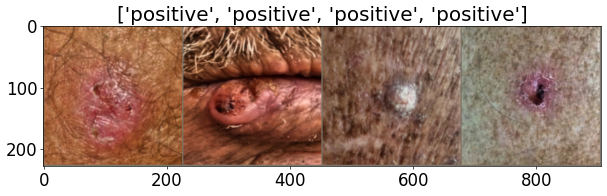

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
model = models.resnet152(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 92.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 2048


In [ ]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0420 Acc: 76.0846% Time: 1493.5812s
[Test #1] Loss: 0.0524 Acc: 75.7576% Time: 1661.9222s
Epoch 1 running
[Train #2] Loss: 0.0343 Acc: 81.8059% Time: 1893.3461s
[Test #2] Loss: 0.0562 Acc: 69.4444% Time: 1911.9639s
Epoch 2 running
[Train #3] Loss: 0.0297 Acc: 84.7072% Time: 2142.7796s
[Test #3] Loss: 0.0418 Acc: 78.7879% Time: 2161.6878s
Epoch 3 running
[Train #4] Loss: 0.0271 Acc: 86.2256% Time: 2390.2600s
[Test #4] Loss: 0.0420 Acc: 79.5455% Time: 2408.8833s
Epoch 4 running
[Train #5] Loss: 0.0240 Acc: 88.4761% Time: 2636.7133s
[Test #5] Loss: 0.0424 Acc: 79.2929% Time: 2655.3705s
Epoch 5 running
[Train #6] Loss: 0.0230 Acc: 88.7744% Time: 2884.2777s
[Test #6] Loss: 0.0509 Acc: 75.7576% Time: 2903.1199s
Epoch 6 running
[Train #7] Loss: 0.0219 Acc: 89.5336% Time: 3133.7712s
[Test #7] Loss: 0.0500 Acc: 73.4848% Time: 3152.7543s
Epoch 7 running
[Train #8] Loss: 0.0200 Acc: 90.6453% Time: 3385.9710s
[Test #8] Loss: 0.0528 Acc: 75.2525% Time: 3405.8763s


In [ ]:
save_path = 'custom-classifier_resnet_152_final.pth'
torch.save(model.state_dict(), save_path)

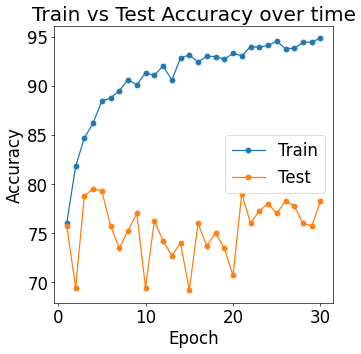

In [ ]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [ ]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth


Accuracy on Training set:  0.7828282828282829
Confusion matrix: 
 [[5910 1230]
 [1350 3390]]
Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      7140
           1       0.73      0.72      0.72      4740

    accuracy                           0.78     11880
   macro avg       0.77      0.77      0.77     11880
weighted avg       0.78      0.78      0.78     11880



<Axes: title={'center': 'Confusion matrix for Skin Cancer classification '}>

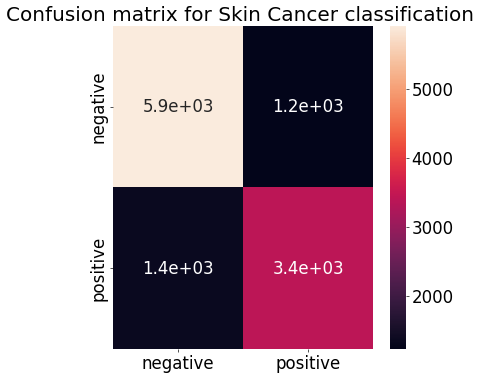

In [ ]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)